#Init

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls
# !cp -r 'drive/My Drive/Aramco/task3' 'Aramco'
!unzip 'drive/My Drive/Aramco/task3.zip' -d 'Aramco' # 'drive/My Drive/Aramco/task3'

drive  sample_data
Archive:  drive/My Drive/Aramco/task3.zip
   creating: Aramco/6201 11-1/
   creating: Aramco/6201 11-2/
   creating: Aramco/6204 10-2 A/
   creating: Aramco/6204 10-2 R/
   creating: Aramco/6204 11-1/
   creating: Aramco/6406 3-2/
   creating: Aramco/6506 12-5/
   creating: Aramco/6507 7-4/
   creating: Aramco/Well X/
  inflating: Aramco/3_Aramco Upstream Solution Technathon 2019_rock_image_final.docx  
  inflating: Aramco/.gitkeep         
  inflating: Aramco/AramcoTechnathon_AI_Challenge_3_Lithofacies_final.pptx  
   creating: Aramco/6507 7-4/Core_images/
   creating: Aramco/6507 7-4/Grainsize/
   creating: Aramco/6507 7-4/Lithology_logs/
   creating: Aramco/6507 7-4/Well_logs/
  inflating: Aramco/6507 7-4/Core_images/6507_7_4_27502_27525.jpg  
  inflating: Aramco/6507 7-4/Core_images/6507_7_4_25585_25599.jpg  
  inflating: Aramco/6507 7-4/Core_images/6507_7_4_25120_25142.jpg  
  inflating: Aramco/6507 7-4/Core_images/6507_7_4_25806_25820.jpg  
  inflating: Aramco/

# Imports

In [0]:
import os
import re
import glob
import random
import time

import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

import tensorflow as tf

import sklearn.cluster as cluster
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle

# Functions

In [0]:
def load_image( infilename ) :
  img = Image.open( infilename )
  img.load()
  data = np.asarray( img, dtype="int32" )

  return data

def show(img, figsize=(10, 20)): 
  fig = plt.figure(figsize=figsize)
  plt.imshow(img)
  plt.show()  

# Deprecated
def decode_segmap(source):
  # Load the foreground input image
  foreground = cv2.imread(source)
  
  # Change the color of foreground image to RGB
  # and resize image to match shape of R-band in RGB output map
  rgb = cv2.resize(foreground, (foreground.shape[1], foreground.shape[0]))
  
  # Create a background array to hold white pixels
  # with the same size as RGB output map
  background = 255 * np.ones_like(rgb).astype(np.uint8)
  
  # Convert uint8 to float
  foreground = foreground.astype(float)
  background = background.astype(float)
  
  # Create a binary mask of the RGB output map using the threshold value 0
  th, alpha = cv2.threshold(np.array(rgb), 0, 255, cv2.THRESH_BINARY)
  
  # Apply a slight blur to the mask to soften edges
  alpha = cv2.GaussianBlur(alpha, (7,7),0)
  
  # Normalize the alpha mask to keep intensity between 0 and 1
  alpha = alpha.astype(float)/255
  
  # Multiply the foreground with the alpha matte
  foreground = cv2.multiply(alpha, foreground)
  
  # Multiply the background with ( 1 - alpha )
  background = cv2.multiply(1.0 - alpha, background)
  
  # Add the masked foreground and background
  outImage = cv2.add(foreground, background)
  
  # Return a normalized output image for display
  return outImage/255

def get_distr_mask(core_img, thresh=0.5, vert=True):
  if vert:
    middle = int(core_img.shape[1] // 2)
    sample = core_img[:, middle - 1:middle + 2].mean(1)[:, None]
    map_ = core_img.copy() - sample
    distr = (map_.mean(0) ** 2).mean(1)

  else:
    middle = int(core_img.shape[0] // 2)
    sample = core_img[middle - 3:middle + 3, :].mean(0)[None]
    map_ = core_img.copy() - sample
    distr = (map_.mean(1) ** 2).mean(1)

  mean = distr.mean()
  # cluster = np.arange(len(distr))[distr < thresh*mean]

  return distr < thresh*mean
  # return cluster[0], cluster[-1]

def preprocess_images(df, dim):
  new_size = (dim, dim*10)

  for id, selection in df.iterrows():

    print('Ratio:', selection.ratio)
    print('Length:', selection['length'])

    img_name = selection.img_name
    core_img = cv2.imread(img_name)

    if selection.img_kind == 0:
      core_img = np.int32(core_img)
      
      height, width = core_img.shape[:2]
      top_f = 0.1
      bottom_f = 0.9
      cores_f = np.linspace(0.1, 0.9, 5)

      for center in cores_f:
        width_f = 0.1
        core = core_img[:, int((center - width_f) * width):int((center + width_f) * width)]
        
        # show(core)

        # Get left-right borders
        distr_mask = get_distr_mask(core, 0.2, vert=True)
        cluster = np.arange(len(distr_mask))[distr_mask]
        left, right = cluster[0], cluster[-1]
        
        # Get top-bottom borders
        distr_mask = get_distr_mask(core, 0.2, vert=False)
        midpoint = np.arange(len(distr_mask))[distr_mask].mean()
        delta = right - left
        top, botttom = max(0, int(midpoint - 5 * delta)), min(int(midpoint + 5 * delta), core.shape[0])

        core_img_cropped = core[top:botttom, left:right]
        # show(core_img_cropped)

      # Resize image to make the DL model train faster
        res = cv2.resize(np.uint8(core_img_cropped), 
                         new_size, 
                         interpolation=cv2.INTER_CUBIC)

        # show(res)
        yield res
            
    elif selection.img_kind == 1:
      true_ratio = 0.1
      crop_size = core_img.shape[1] / selection.ratio * (selection.ratio - true_ratio) // 2
      crop_size = int(crop_size)

      if crop_size > 0:
        core_img = core_img[:, crop_size:-crop_size]
      # show(core_img)

      # Resize image to make the DL model train faster
      res = cv2.resize(core_img, dsize=new_size, interpolation=cv2.INTER_CUBIC)
      
      # show(res)
      yield res

    else:
      true_width = 0.1 # meters
      # show(core_img)

      selection.length = selection.ratio
      
      # Resize image to make the DL model train faster
      res = cv2.resize(core_img, 
                      dsize=(new_size[0], int(new_size[0]*selection.length*10)), 
                      interpolation=cv2.INTER_CUBIC)
      # show(res)
      yield res

def preprocess_logs(dim, filnames, log_map):
  data = {}

  for well_id in filnames:

    filename = filnames[well_id]
    
    files = glob.glob('Aramco/**/**{}'.format(filename), recursive=True)

    for filename in files:
      log = {}

      print(filename)

      # l_log = load_image(filename)
      l_log = cv2.imread(filename)
      print(l_log.shape)

      column_0, column_1, depths = [], [], []
      for split in log_map[well_id]:
        x, y, d = split.values()

        # column0
        delta = x[1] - x[0]
        img = l_log[y[0]:y[1], x[0]:x[1]]
        res = cv2.resize(img, dsize=(dim, int(dim / img.shape[1] * img.shape[0])), 
                        interpolation=cv2.INTER_CUBIC)
        column_0.append(res)
        # show(column_0[-1][:delta])
        # show(column_0[-1][-delta:])
        
        # column1
        img = l_log[y[0]:y[1], x[2]:x[2] + delta]
        res = cv2.resize(img, dsize=(dim, int(dim / img.shape[1] * img.shape[0])), 
                        interpolation=cv2.INTER_CUBIC)
        column_1.append(res)
        # show(column_1[-1][:delta])
        # show(column_1[-1][-delta:])

        # depth
        depths.append(d[0] + np.arange(len(res)) * (d[1] - d[0]) / len(res))

      data[well_id] = [column_0, column_1, depths]

  return data

# VQ_VAE

## Bricks

In [0]:
act = tf.keras.layers.LeakyReLU(0.4)
# act = tf.keras.layers.ReLU()
    
class Residual(tf.keras.layers.Layer):  
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens, name):
    self.args = num_hiddens, num_residual_layers, num_residual_hiddens, name
    
    super(Residual, self).__init__()
    
    self.layers = [[
        act,
        
        tf.keras.layers.Conv2D(
          num_residual_hiddens,
          kernel_size=(3, 3),
          strides=(1, 1),
          padding='same',
          name="res3x3"),
        
        act,
        
        tf.keras.layers.Conv2D(
          filters=num_hiddens,
          kernel_size=(1, 1),
          padding='same',
          strides=(1, 1),
          name="res1x1")
    ]]*num_residual_layers
    
    self.relu = act
    
  def call(self, inputs):
    num_hiddens, num_residual_layers, num_residual_hiddens, name = self.args
    
    for res in self.layers:
      h = inputs
      for layer in res:
        h = layer(h)
      inputs += h
            
    return self.relu(inputs)

class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='encoder'):
    super(Encoder, self).__init__()

    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
    
    self.layers = [
        tf.keras.layers.Conv2D(
        filters=self._num_hiddens // 2,
        kernel_size=(4, 4),
        strides=(2, 2),
        padding='same'),
        
        act,
        
        tf.keras.layers.Conv2D(
        filters=self._num_hiddens // 2,
        kernel_size=(4, 4),
        strides=(2, 2),
        padding='same'),
        
        act,
        
        # tf.keras.layers.Conv2D(
        # filters=self._num_hiddens // 2,
        # kernel_size=(4, 4),
        # strides=(2, 2),
        # padding='same'),
        
        # act,
        
        # tf.keras.layers.Conv2D(
        # filters=self._num_hiddens // 2,
        # kernel_size=(4, 4),
        # strides=(2, 2),
        # padding='same'),
        
        # act,
        
        tf.keras.layers.Conv2D(
        filters=self._num_hiddens // 2,
        kernel_size=(4, 4),
        strides=(2, 2),
        padding='same'),
        
        act,
        
        tf.keras.layers.Conv2D(
        filters=self._num_hiddens,
        kernel_size=(4, 4),
        strides=(2, 2),
        padding='same',
        name="enc_2"),
        
        act,
        
        tf.keras.layers.Conv2D(
        filters=self._num_hiddens,
        kernel_size=(3, 3),
        strides=(1, 1),
        padding='same',
        name="enc_3"),
        
        Residual(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens,
        "enc")
    ]
    print(self.layers)
    
  def call(self, inputs):

    h = inputs
    for layer in self.layers:
      h = layer(h)
  
    return h

class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_hiddens, num_residual_layers, num_residual_hiddens,
               name='decoder'):

    self._num_hiddens = num_hiddens
    self._num_residual_layers = num_residual_layers
    self._num_residual_hiddens = num_residual_hiddens
    
    super(Decoder, self).__init__()
    
    self.layers = [
        tf.keras.layers.Conv2D(
            filters=self._num_hiddens,
            kernel_size=(3, 3),
            strides=(1, 1),
            padding='same',
            name="dec_1"),
        
        Residual(
        self._num_hiddens,
        self._num_residual_layers,
        self._num_residual_hiddens,
        "dec"),
        
        tf.keras.layers.Conv2DTranspose(
        filters=int(self._num_hiddens // 2),
        kernel_size=(4, 4),
        strides=(2, 2),
        padding='same',
        name="dec_2"),
        
        act,
        
        # tf.keras.layers.Conv2DTranspose(
        # filters=int(self._num_hiddens // 2),
        # kernel_size=(4, 4),
        # strides=(2, 2),
        # padding='same'),
        
        # act,
        
        # tf.keras.layers.Conv2DTranspose(
        # filters=int(self._num_hiddens // 2),
        # kernel_size=(4, 4),
        # strides=(2, 2),
        # padding='same'),
        
        # act,
        
        tf.keras.layers.Conv2DTranspose(
        filters=int(self._num_hiddens // 2),
        kernel_size=(4, 4),
        strides=(2, 2),
        padding='same'),
        
        act,
        
        tf.keras.layers.Conv2DTranspose(
        filters=int(self._num_hiddens // 2),
        kernel_size=(4, 4),
        strides=(2, 2),
        padding='same'),
        
        act,
        
        tf.keras.layers.Conv2DTranspose(
        filters=3,
        kernel_size=(4, 4),
        strides=(2, 2),
        padding='same',
        activation='sigmoid',
        name="dec_3")
    ]
    
  def call(self, inputs):

    h = inputs
    for layer in self.layers:
      h = layer(h)
  
    return h

## VectorQuantizer

In [0]:
class VectorQuantizer(tf.keras.layers.Layer):
  """Sonnet module representing the VQ-VAE layer.
  Implements the algorithm presented in
  'Neural Discrete Representation Learning' by van den Oord et al.
  https://arxiv.org/abs/1711.00937
  Input any tensor to be quantized. Last dimension will be used as space in
  which to quantize. All other dimensions will be flattened and will be seen
  as different examples to quantize.
  The output tensor will have the same shape as the input.
  For example a tensor with shape [16, 32, 32, 64] will be reshaped into
  [16384, 64] and all 16384 vectors (each of 64 dimensions)  will be quantized
  independently.
  Args:
    embedding_dim: integer representing the dimensionality of the tensors in the
      quantized space. Inputs to the modules must be in this format as well.
    num_embeddings: integer, the number of vectors in the quantized space.
    commitment_cost: scalar which controls the weighting of the loss terms
      (see equation 4 in the paper - this variable is Beta).
  """

  def __init__(self, num_embeddings, commitment_cost, decay=None, epsilon=1e-5, **kwargs):
    super(VectorQuantizer, self).__init__(**kwargs)
    self._num_embeddings = num_embeddings
    self._commitment_cost = commitment_cost
    self._decay = decay
    self._epsilon = epsilon
    self._trainable = False if self._decay else True
    self._use_resource = True if self._decay else False
  
  def build(self, input_shape):
    input_shape = input_shape.as_list()
    
    initializer = tf.uniform_unit_scaling_initializer()
    self._w = self.add_weight('embedding', [input_shape[-1], self._num_embeddings], tf.float32,
                              initializer=initializer, trainable=True)
    
#     self._tanh = tf.nn.tanh(self.add_weight('tanh', [input_shape[-1], 1], tf.float32,
#                                             trainable=self._trainable))
    self._tanh = tf.Variable(tf.range(input_shape[-1], dtype=tf.float32), trainable=False)[..., None]
    self.num = self.add_weight('num', [1],
                          initializer=tf.keras.initializers.Zeros(),
                          trainable=self._trainable)

    self._tanh = tf.nn.tanh(self._tanh - tf.nn.tanh(self.num)*input_shape[-1])

    self._tanh_max = 1.0 - tf.maximum(0.0, tf.sign(-self._tanh))
    self._tanh_grad = self._tanh + tf.stop_gradient(self._tanh_max - self._tanh)
#     self._w = self._tanh_grad * self._w
    
    self.built = True

  def call(self, inputs, is_training):
    """Connects the module to some inputs.
    Args:
      inputs: Tensor, final dimension must be equal to embedding_dim. All other
        leading dimensions will be flattened and treated as a large batch.
      is_training: boolean, whether this connection is to training data.
    Returns:
      dict containing the following keys and values:
        quantize: Tensor containing the quantized version of the input.
        loss: Tensor containing the loss to optimize.
        perplexity: Tensor containing the perplexity of the encodings.
        encodings: Tensor containing the discrete encodings, ie which element
          of the quantized space each input element was mapped to.
        encoding_indices: Tensor containing the discrete encoding indices, ie
          which element of the quantized space each input element was mapped to.
    """

    flat_inputs = tf.reshape(inputs, [-1, tf.shape(inputs)[-1]])

    distances = (tf.reduce_sum(flat_inputs**2, 1, keepdims=True)
                 - 2 * tf.matmul(flat_inputs, self._w)
                 + tf.reduce_sum(self._w ** 2, 0, keepdims=True))

    encoding_indices = tf.argmax(- distances, 1)
    encodings = tf.one_hot(encoding_indices, self._num_embeddings)
    encoding_indices = tf.reshape(encoding_indices, tf.shape(inputs)[:-1])
    
    quantized = self.quantize(encoding_indices)

    e_latent_loss = tf.reduce_mean((tf.stop_gradient(quantized) - inputs) ** 2)
    q_latent_loss = tf.reduce_mean((quantized - tf.stop_gradient(inputs)) ** 2)
    loss = q_latent_loss + self._commitment_cost * e_latent_loss# + tf.reduce_mean(self._tanh_grad)
    
    quantized = inputs + tf.stop_gradient(quantized - inputs)
    avg_probs = tf.reduce_mean(encodings, 0)
    perplexity = tf.exp(- tf.reduce_sum(avg_probs * tf.log(avg_probs + 1e-10)))

    return {'quantize': quantized,
            'loss': loss,
            'perplexity': perplexity,
            # 'encodings': encodings,
            'encodings': tf.reshape(encodings, (-1, inputs.shape[1]*inputs.shape[2], self._num_embeddings)),
            'encoding_indices': encoding_indices,}

  @property
  def embeddings(self):
    return self._w

  def quantize(self, encoding_indices):
    return tf.nn.embedding_lookup(tf.transpose(self._w, [1, 0]), encoding_indices, validate_indices=False)

#Парсим имена для структуризации данных

In [0]:
files = glob.glob('Aramco/**/Core_images/**.jpg', recursive=True)
data = []
for filename in files:
  core = {}
  print(filename)
  # core_img = load_image(filename)

  if 'Well X' in filename:
    core['well_info'] = [0] + re.findall(r'\d+', filename)
  else:
    core['well_info'] = re.findall(r'\d+', filename)

  core['well_info'] = re.findall(r'\d+', filename)
  core['img_name'] = filename
  data.append(core)

  # input(core['well'])
  # print(core_img.shape)
  # fig = plt.figure(figsize=(10,20))
  # plt.imshow(core_img)
  # plt.show()
  # input()

Aramco/6507 7-4/Core_images/6507_7_4_27589_27613.jpg
Aramco/6507 7-4/Core_images/6507_7_4_24424_24447.jpg
Aramco/6507 7-4/Core_images/6507_7_4_26925_26948.jpg
Aramco/6507 7-4/Core_images/6507_7_4_27362_27386.jpg
Aramco/6507 7-4/Core_images/6507_7_4_25540_25563.jpg
Aramco/6507 7-4/Core_images/6507_7_4_25914_25928.jpg
Aramco/6507 7-4/Core_images/6507_7_4_26638_26661.jpg
Aramco/6507 7-4/Core_images/6507_7_4_25803_25826.jpg
Aramco/6507 7-4/Core_images/6507_7_4_26532_26555.jpg
Aramco/6507 7-4/Core_images/6507_7_4_24704_24727.jpg
Aramco/6507 7-4/Core_images/6507_7_4_25863_25886.jpg
Aramco/6507 7-4/Core_images/6507_7_4_24860_24883.jpg
Aramco/6507 7-4/Core_images/6507_7_4_26026_26049.jpg
Aramco/6507 7-4/Core_images/6507_7_4_26520_26543.jpg
Aramco/6507 7-4/Core_images/6507_7_4_25035_25049.jpg
Aramco/6507 7-4/Core_images/6507_7_4_27421_27444.jpg
Aramco/6507 7-4/Core_images/6507_7_4_26263_25286.jpg
Aramco/6507 7-4/Core_images/6507_7_4_26155_26177.jpg
Aramco/6507 7-4/Core_images/6507_7_4_25621_256

In [0]:
for row in data:
  well_info = row['well_info']

  if len(well_info) == 8:
    for idx in range(4):
      row['id_{}'.format(idx)] = int(well_info[idx])
    row['id_4'] = None

  elif len(well_info) == 7:
    for idx in range(5):
      row['id_{}'.format(idx)] = int(well_info[idx])

  else:
    for idx in range(5):
      row['id_{}'.format(idx)] = None
    row['id_{}'.format(0)] = 0

  row['upper'] = int(well_info[-2])
  row['lower'] = int(well_info[-1])
  row['length'] = row['lower'] - row['upper']

  core_img = load_image(row['img_name'])

  row['height'], row['width'] = core_img.shape[:2]
  row['ratio'] = row['width'] / row['height'] 

  del core_img
  del row['well_info']

  # Check depth values
  # if row['upper'] >= row['lower']:
  #   print(row['upper'], row['lower'])

  # if l != len(well_info):
  # if '6507' in well_info:
    # print(well_info)
    # l = len(well_info)

In [0]:
df = pd.DataFrame(data)
df

,img_name,id_0,id_1,id_2,id_3,id_4,upper,lower,length,height,width,ratio
0,Aramco/6507 7-4/Core_images/6507_7_4_27589_276...,6507,7.0,4.0,6507.0,NaN,27589,27613,24,3474,762,0.219344
1,Aramco/6507 7-4/Core_images/6507_7_4_24424_244...,6507,7.0,4.0,6507.0,NaN,24424,24447,23,3363,759,0.225691
2,Aramco/6507 7-4/Core_images/6507_7_4_26925_269...,6507,7.0,4.0,6507.0,NaN,26925,26948,23,3486,792,0.227194
3,Aramco/6507 7-4/Core_images/6507_7_4_27362_273...,6507,7.0,4.0,6507.0,NaN,27362,27386,24,3471,810,0.233362
4,Aramco/6507 7-4/Core_images/6507_7_4_25540_255...,6507,7.0,4.0,6507.0,NaN,25540,25563,23,3477,813,0.233822
...,...,...,...,...,...,...,...,...,...,...,...,...
1644,Aramco/6204 11-1/Core_images/2205_06_2138-2143...,6204,11.0,1.0,2205.0,6.0,2138,2143,5,3420,2376,0.694737
1645,Aramco/6204 10-2 A/Core_images/3280_02_2110-21...,6204,10.0,2.0,3280.0,2.0,2110,2115,5,3402,2364,0.694885
1646,Aramco/6204 10-2 A/Core_images/3280_01_2105-21...,6204,10.0,2.0,3280.0,1.0,2105,2110,5,3417,2370,0.693591
1647,Aramco/6204 10-2 A/Core_images/3280_04_2120-21...,6204,10.0,2.0,3280.0,4.0,2120,2121,1,3390,2370,0.699115


# Check indexes 

In [0]:
df.id_0.value_counts()

6507    514
6506    440
0       329
6406    293
6201     39
6204     34
Name: id_0, dtype: int64

In [0]:
df.id_3.value_counts()

6507.0    514
6506.0    440
6406.0    293
1134.0     36
2205.0     24
3258.0      6
3280.0      4
1549.0      3
Name: id_3, dtype: int64

In [0]:
df.query('id_0 == 6204').groupby('id_0')['id_3'].value_counts()

id_0  id_3  
6204  2205.0    24
      3258.0     6
      3280.0     4
Name: id_3, dtype: int64

# Check height, width and ratio 

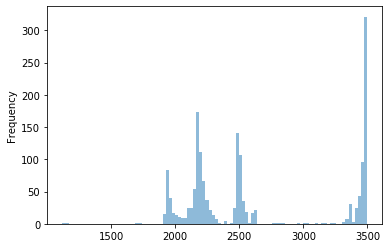

In [0]:
ax = df.height.plot.hist(bins=100, alpha=0.5)

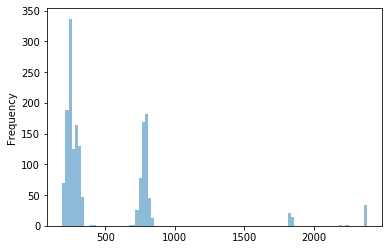

In [0]:
ax = df.width.plot.hist(bins=100, alpha=0.5)

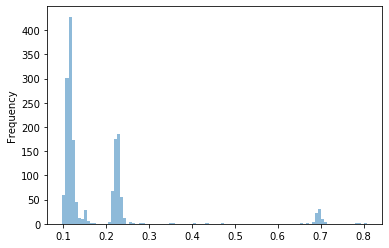

In [0]:
ax = df.ratio.plot.hist(bins=100, alpha=0.5)

# Use RFC to predict num of core samples in the images

In [0]:
x_train = df.query('id_0 != 0')[['ratio', 'height', 'width', 'length']]
x_test = df.query('id_0 == 0')[['ratio', 'height', 'width', 'length']]

In [0]:
y_train = df.query('id_0 != 0')['id_0'].map({6201: 0, 6204: 0, 6406: 1, 6506: 1, 6507: 2}).rename('label')
y_test = df.query('id_0 == 0')['id_0'].rename('label') + 1

In [0]:
if False:
  rfc = RandomForestClassifier(random_state=42, n_jobs=-1)

  param_grid = { 
      'n_estimators': [20, 30, 40, 50, 60],
      'max_depth' : [2, 3, 4, 5, 6, 7, 8],
      'min_samples_split': [2, 4, 6],
      'min_samples_leaf': [2, 4, 6],
  }

  CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv=5, verbose=2, scoring='accuracy')
  CV_rfc.fit(*shuffle(x_train, y_train))

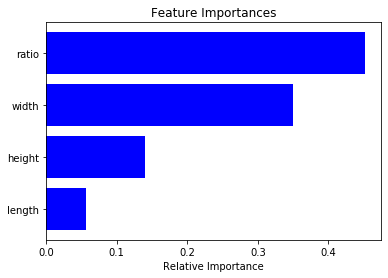

Test acc: 1.0
Train acc: 1.0


In [0]:
try:
  print('Best params:', CV_rfc.best_params_)
  rfc = CV_rfc.best_estimator_
except:
  pass

rfc = RandomForestClassifier(random_state=42, n_jobs=-1, **{ 
    'n_estimators': 40,
    'max_depth' : 3,
    'min_samples_split': 2,
    'min_samples_leaf': 2,
})

rfc.fit(x_train, y_train)

# Plot feature importance
features = x_train.columns
importances = rfc.feature_importances_
indices = np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

print('Test acc:', accuracy_score(y_test, rfc.predict(x_test)))
print('Train acc:', accuracy_score(y_train, rfc.predict(x_train)))

In [0]:
df['img_kind'] = rfc.predict(df[['ratio', 'height', 'width', 'length']])
df[df.img_name == 'Aramco/6204 11-1/Core_images/2205_02_2013-2026m.jpg'].img_kind

1629    0
Name: img_kind, dtype: int64

# Lithology log parser

In [0]:
FILENAMES = {
    6406: 'fixed2_6406_3_2.tiff', 
    6506: 'fixed_6506_12_5.tiff',
    6507: 'WB_MULTIPLE_WELLS__ROCK_AND_CORE__CORE_DESC_REPORT_4_ENCL_29.TIF', 
           }

LOG_MAP = {
    6406: [{'x': [1073, 1181, 1200], 'y': [4395, 13029], 'd': [3930, 4148]},
           {'x': [1073, 1181, 1200], 'y': [14531, 18193], 'd': [4282, 4376]}], 
    6506: [{'x': [877, 985, 1000], 'y': [3881, 5463], 'd': [3148, 3188]},
           {'x': [877, 985, 1000], 'y': [6387, 23027], 'd': [3944, 4362]}],
    6507: [{'x': [923, 1031, 1045], 'y': [4545, 17311], 'd': [2450, 2767]}], 
           }

In [0]:
DIM = 64
l_logs = preprocess_logs(DIM, FILENAMES, LOG_MAP)

for well_k in l_logs:
  data = []
  for rows in l_logs[well_k]:
    data.append(np.concatenate(rows))
  l_logs[well_k] = data

Aramco/6406 3-2/Lithology_log/fixed2_6406_3_2.tiff
(21556, 3456, 3)
Aramco/6506 12-5/Lithology_logs/fixed_6506_12_5.tiff
(24109, 2834, 3)
Aramco/6507 7-4/Lithology_logs/WB_MULTIPLE_WELLS__ROCK_AND_CORE__CORE_DESC_REPORT_4_ENCL_29.TIF
(19008, 2832, 3)


# Preprocess the data

In [0]:
df = pd.read_csv('drive/My Drive/Aramco/dataset.csv')
# df.to_csv('drive/My Drive/Aramco/dataset.csv', index=False)

df = df.sort_values(['id_0', 'upper'], ascending=True)
df

,img_name,id_0,id_1,id_2,id_3,id_4,upper,lower,length,height,width,ratio,img_kind
0,Aramco/Well X/Core_images/Well_X_4184_4185.jpg,0,NaN,NaN,NaN,NaN,4184,4185,1,2493,317,0.127156,1
1,Aramco/Well X/Core_images/Well_X_4185_4186.jpg,0,NaN,NaN,NaN,NaN,4185,4186,1,2493,294,0.117930,1
2,Aramco/Well X/Core_images/Well_X_4186_4187.jpg,0,NaN,NaN,NaN,NaN,4186,4187,1,2482,289,0.116438,1
3,Aramco/Well X/Core_images/Well_X_4187_4188.jpg,0,NaN,NaN,NaN,NaN,4187,4188,1,2482,300,0.120870,1
4,Aramco/Well X/Core_images/Well_X_4188_4189.jpg,0,NaN,NaN,NaN,NaN,4188,4189,1,2515,287,0.114115,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1644,Aramco/6507 7-4/Core_images/6507_7_4_27622_276...,6507,7.0,4.0,6507.0,NaN,2762,2764,23,3483,759,0.217916,2
1645,Aramco/6507 7-4/Core_images/6507_7_4_27631_276...,6507,7.0,4.0,6507.0,NaN,2763,2765,24,3483,774,0.222222,2
1646,Aramco/6507 7-4/Core_images/6507_7_4_27637_276...,6507,7.0,4.0,6507.0,NaN,2763,2766,23,3483,775,0.222509,2
1647,Aramco/6507 7-4/Core_images/6507_7_4_27643_276...,6507,7.0,4.0,6507.0,NaN,2764,2766,22,3401,729,0.214349,2


In [0]:
DIM = 64
images = []
np.empty(shape=(DIM*10, DIM))
for (id, row), image in zip(df.iterrows(), preprocess_images(df=df, dim=DIM)):
  images.append(image)

Ratio: 0.12715603690332933
Length: 1
Ratio: 0.11793020457280386
Length: 1
Ratio: 0.11643835616438356
Length: 1
Ratio: 0.12087026591458501
Length: 1
Ratio: 0.11411530815109346
Length: 1
Ratio: 0.11271560369033293
Length: 1
Ratio: 0.11070998796630566
Length: 1
Ratio: 0.11953469715202568
Length: 1
Ratio: 0.12340255591054312
Length: 1
Ratio: 0.12164865946378553
Length: 1
Ratio: 0.13019169329073482
Length: 1
Ratio: 0.12610088070456366
Length: 1
Ratio: 0.1301040832666133
Length: 1
Ratio: 0.12735282338806567
Length: 1
Ratio: 0.12158908507223115
Length: 1
Ratio: 0.1187800963081862
Length: 1
Ratio: 0.12460063897763578
Length: 1
Ratio: 0.13298722044728434
Length: 1
Ratio: 0.11980830670926518
Length: 1
Ratio: 0.11809447558046438
Length: 1
Ratio: 0.12151002752654345
Length: 1
Ratio: 0.12962226640159047
Length: 1
Ratio: 0.1253968253968254
Length: 1
Ratio: 0.125
Length: 1
Ratio: 0.12485089463220675
Length: 1
Ratio: 0.16052842273819054
Length: 1
Ratio: 0.11724415793714744
Length: 1
Ratio: 0.117647058

# Build the Graph


In [0]:
tf.reset_default_graph()

# Set hyper-parameters.
batch_size = 32
image_size = 32
data_variance = 1

# 100k steps should take < 30 minutes on a modern (>= 2017) GPU.
num_iters = 5000

num_hiddens = 32
num_residual_hiddens = 64
num_residual_layers = 2

# This value is not that important, usually 64 works.
# This will not change the capacity in the information-bottleneck.
embedding_dim = 32

# The higher this value, the higher the capacity in the information bottleneck.
num_embeddings = 512

# commitment_cost should be set appropriately. It's often useful to try a couple
# of values. It mostly depends on the scale of the reconstruction cost
# (log p(x|z)). So if the reconstruction cost is 100x higher, the
# commitment_cost should also be multiplied with the same amount.
commitment_cost = 0.25

# Use EMA updates for the codebook (instead of the Adam optimizer).
# This typically converges faster, and makes the model less dependent on choice
# of the optimizer. In the VQ-VAE paper EMA updates were not used (but was
# developed afterwards). See Appendix of the paper for more details.
vq_use_ema = False

# This is only used for EMA updates.
decay = 0.99

lr = tf.placeholder(tf.float32)

# Build modules.
encoder = Encoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder_true = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder_col0 = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)
decoder_col1 = Decoder(num_hiddens, num_residual_layers, num_residual_hiddens)

pre_vq_conv1 = tf.keras.layers.Conv2D(filters=embedding_dim,
    kernel_size=(1, 1),
    strides=(1, 1),
    padding='same',
    name="to_vq")

vq_vae = VectorQuantizer(
    num_embeddings=num_embeddings,
    commitment_cost=commitment_cost)

# Process inputs with conv stack, finishing with 1x1 to get to correct size.
x = tf.placeholder(tf.float32, shape=(None, DIM, DIM, 3))
y_col0 = tf.placeholder(tf.float32, shape=(None, DIM, DIM, 3))
y_col1 = tf.placeholder(tf.float32, shape=(None, DIM, DIM, 3))

z = pre_vq_conv1(encoder(x))

# For training
# vq_output_train = vq_vae(z, is_training=True)
# x_recon_true = decoder_true(vq_output_train["quantize"])
# x_recon_col0 = decoder_col0(vq_output_train["quantize"])
# x_recon_col1 = decoder_col1(vq_output_train["quantize"])

# For evaluation, make sure is_training=False!
# vq_output_eval = vq_vae(z, is_training=False)
# x_recon_eval_true = decoder(vq_output_eval["quantize"])
# x_recon_eval_col0 = decoder(vq_output_eval["quantize"])
# x_recon_eval_col1 = decoder(vq_output_eval["quantize"])

# Define losses and metrics
# recon_error_mse = tf.reduce_mean((x_recon - x)**2) / data_variance  # Normalized MSE
# recon_error_bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_recon)) / data_variance
# recon_error_eva_bce = tf.reduce_mean(tf.keras.losses.binary_crossentropy(x, x_recon_eval))
# recon_error_eval_mse = tf.reduce_mean((x_recon_eval - x)**2) / data_variance  # Normalized MSE
# loss_true = recon_error_mse + vq_output_train["loss"]
# loss_cols1 = recon_error_mse + vq_output_train["loss"]

# New
vq_output_train = vq_vae(z, is_training=True)
vq_output_eval = vq_vae(z, is_training=False)

losses, x_recons, x_recons_eval, recon_errors_mse = [], [], [], []
for decoder, y_true in zip([decoder_true, decoder_col0, decoder_col1],
                           [x, y_col0, y_col1]):
  
  x_recons.append(decoder(vq_output_train["quantize"]))
  x_recons_eval.append(decoder(vq_output_eval["quantize"]))

  # Define losses and metrics
  recon_errors_mse.append(tf.reduce_mean((x_recons[-1] - y_true)**2) / data_variance)  # Normalized MSE
  losses.append(recon_errors_mse[-1] + vq_output_train["loss"])

loss_true = losses[0]
loss_cols = sum(losses) / 3
loss_eval = tf.reduce_mean((decoder_true(vq_output_eval["quantize"]) - x)**2) / data_variance  # Normalized MSE

# TODO: Use!!!
features = vq_output_eval["encoding_indices"]

# input(features)

# Create optimizer and TF session.
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_op_true = optimizer.minimize(loss_true)
train_op_cols = optimizer.minimize(loss_cols)
sess = tf.train.SingularMonitoredSession()

ListWrapper([<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f95e00933c8>, <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f95e092a240>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f95e00939e8>, <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f95e092a240>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f95e00970f0>, <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f95e092a240>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f95e00977b8>, <tensorflow.python.keras.layers.advanced_activations.LeakyReLU object at 0x7f95e092a240>, <tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7f95e0097e80>, <__main__.Residual object at 0x7f95e0098358>])
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform t

# Train the DL model to exctract meaningful features form the available data

In [0]:
depths = df.upper
wells = df.id_0
tracked_wells = [6506, 6507, 6406]

class Sampler:
  def __init__(self, images, wells, depths, depths_c=None, l_logs=None):
    self.images=images 
    self.wells = wells.reset_index(drop=True)
    self.depths = depths
    self.depths_c = depths_c
    self.l_logs = l_logs

    self.proba = 1.0
    self.aug = False
  
  def augment(self, aug=True, proba=0.3):
    self.aug = aug
    self.proba = (1 - proba)
    return self

  def get_batch(self, batch_size=64, iters=100, use_depth=True):

    for iter in range(iters):
      cols_0, cols_1 = [], []
      # Randomly choose either to train on wells with additional logs or without
      if random.random() >= 0.5:
        indexes = self.wells[self.wells.isin(tracked_wells)].sample(batch_size).index.values
        depths = self.depths[indexes]
        for well_id, depth in zip(self.wells[indexes], depths):
          well_logs = self.l_logs[well_id]
          col_0, col_1, d = well_logs

          dim = col_0.shape[1]
          dist = (d - depth) ** 2

          arg = min(np.argmin(dist), col_0.shape[0] - dim)
          cols_0.append(col_0[None, arg:arg+dim])
          cols_1.append(col_1[None, arg:arg+dim])

        cols_0 = np.concatenate(cols_0)
        cols_1 = np.concatenate(cols_1)

      else:
        indexes = self.wells[~self.wells.isin(tracked_wells)].sample(batch_size).index.values

      samples = [self.images[i] for i in indexes]

      dim = samples[0].shape[1]

      array = np.zeros(shape=(batch_size, dim, dim, 3), dtype=np.int32)
      for num, core in enumerate(samples):
        max_size = core.shape[0] - dim
        if max_size < dim:
          raise Exception(123)
        
        # Subsample from core
        indx = random.randint(0, max_size)
        
        # TODO: Sample by middle point
        img = core[indx:indx+dim]
      
        # Simple data augmentation
        if self.aug:
          if random.random() >= self.proba:
            img = img[::-1]
          if random.random() >= self.proba:
            img = img[:, ::-1]

        array[num] = img

      if use_depth:
        yield np.concatenate([array / 255, self.depths_c[indexes]], axis=-1)
      else:
        if cols_0 == []:
          yield array / 255
        else:
          yield array / 255, cols_0 / 255, cols_1 / 255

# Prepare depths to feed as the additional channels
depths_ = depths / depths.mean()
depths_ = depths_[:, None, None, None]
depths_ = np.tile(depths_, [1, DIM, DIM, 3])
depths_ = np.cumprod(depths_, -1)

sampler = Sampler(images, wells, depths.values, depths_, l_logs) 

start = time.time()
for batch in sampler.augment().get_batch(batch_size=64, iters=num_iters*10, use_depth=False):
  if len(batch) == 3:
    # Train full
    results = sess.run([train_op_cols, loss_true, loss_cols, loss_eval], 
                       feed_dict={lr: 1e-3, **dict(zip([x, y_col0, y_col1], batch))})
    recons = sess.run(x_recons_eval,
                      feed_dict={x: batch[0]})
    # show(recons[0][10])
    # show(batch[1][10])
    # input(recons[0].shape)
    # print(results[1:])
    # input()
  else:
    # Train partial
    results = sess.run([train_op_true, loss_true, loss_eval], 
                       feed_dict={lr: 1e-3, x: batch})
    print(results[1:])

# Evaluate on X_well data

In [0]:
indexes = wells[wells == 0].index.values
X_well = [images[i] for i in indexes]

In [0]:
# pd.DataFrame(data=depths.values[indexes], columns=['depth', 'features'])
feats = []
for img in X_well:
  feats.append(sess.run(features, {x: img.reshape(10, 64, 64, -1) / 255}).reshape(10, -1).mean(0)[None])
  recon = sess.run(x_recons_eval, {x: img.reshape(10, 64, 64, -1) / 255})
  # show(recon[0][0])
  # show(recon[0][1])
  # show(recon[0][2])
  # input()
  # print(feat)
  # input(depth)
  # show([0])
  # input()
  # print(img.shape)
results = pd.DataFrame(np.concatenate(feats))
# results['depth'] = depths.values[indexes]

In [0]:
results

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,251.5,306.7,271.0,389.0,347.2,324.4,227.7,241.6,363.8,309.4,380.1,411.6,399.0,333.8,391.0,371.7
1,294.2,386.4,285.3,279.9,297.3,284.1,287.9,344.4,315.1,300.3,314.0,347.4,317.3,342.8,316.1,312.5
2,243.3,329.2,363.1,267.1,283.3,350.6,210.3,226.2,152.6,263.0,274.7,299.1,253.0,334.6,314.1,253.7
3,292.1,346.3,255.4,285.6,307.8,307.7,292.7,309.5,243.9,265.2,297.1,292.2,241.9,295.9,328.4,258.9
4,301.2,324.7,242.9,176.0,329.9,282.6,232.7,237.7,265.6,368.5,203.5,242.8,373.0,385.0,227.7,258.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
324,221.1,211.1,234.3,278.1,197.7,198.1,265.2,209.6,231.7,252.0,315.0,284.4,208.5,198.6,222.8,265.6
325,313.7,176.2,305.2,338.3,329.3,160.7,285.4,258.1,227.6,233.7,207.7,274.1,202.5,227.4,216.2,253.8
326,216.0,242.0,175.9,248.7,207.7,213.5,274.3,255.4,225.3,161.3,132.0,182.8,264.8,242.1,256.4,236.8
327,289.4,324.2,194.3,215.8,261.2,191.7,309.2,370.9,201.0,258.5,324.9,281.2,241.6,304.4,330.0,335.5


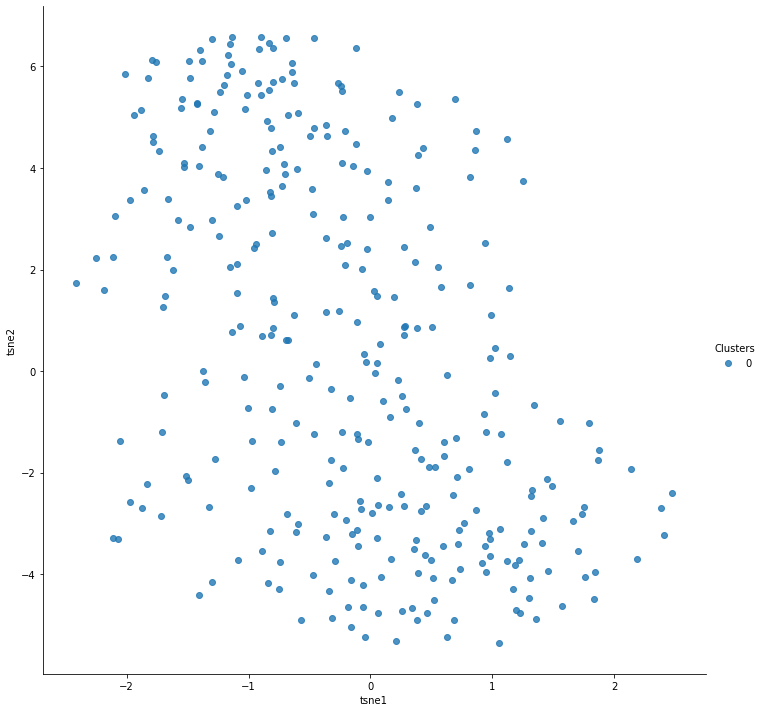

In [0]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
# results_ = StandardScaler().fit_transform(results)
tsne_2d = TSNE(n_components = 2, random_state = 60, perplexity = 100)
tsne_repr_2d = tsne_2d.fit_transform(results)
# results = pd.DataFrame(results)

import seaborn as sns
import random
from sklearn.cluster import DBSCAN

# colors = pd.read_excel('../Desktop/Dataframes/Others/colors.xlsx')  #  библиотека красивых цветов
# list(colors.iloc[:,0])
# colors  = colors.iloc[:,0].str.strip()

# random.shuffle(colors)

labels_dbs = DBSCAN(eps = 2.0, min_samples=17).fit_predict(tsne_repr_2d)
results['Clusters'] = labels_dbs


results['tsne1'] = tsne_repr_2d[:, 0]
results['tsne2'] = tsne_repr_2d[:, 1]
final_result = results[results['Clusters'] != -1]


sns.lmplot('tsne1', 'tsne2', data=final_result, hue = 'Clusters', fit_reg=False, height=10) # , palette=sns.xkcd_palette(colors)
plt.show()

# Fix dump data

Check depth values 

In [0]:
# df = df.sort_values(['id_0', 'upper'], ascending=True)
df.query('img_kind == 0')['length'] = 5#'length']
# ['img_kind'#.query('length is 1 where img_kind == 0')
# df.sort_values(['id_0', 'upper'], ascending=True).query('where img_kind == 0')

In [0]:
df.query('img_kind == 0')[['upper', 'lower']]

In [0]:
df.query('img_kind == 0').upper.diff() < 5

In [0]:
mask = df.query('img_kind == 0')[['upper', 'lower']].diff(axis=1).lower != 4

In [0]:
df.query('img_kind == 0')[mask]

In [0]:
for id, f in df.copy().query('img_kind == 0').groupby('id_0'):
  # f.upper = f.lower - 4
  arr = f[['upper', 'lower']].values
  print(np.diff(arr, axis=0))
  print(arr)
  # print(arr)  
  # print(f.length)
  args = np.argwhere(np.diff(arr) <= 0)
  # print(np.diff(arr))
  # print(arr[args])
  # print()
  # print(arr[args + 1])

# values.reshape(-1)

In [0]:
np.diff(df.query('img_kind == 0')[['upper', 'lower']].values.reshape(-1))

In [0]:
n_clusters=5

for id, row in df.query('length <= 0').iterrows():
  core_img = load_image(row['img_name'])
  print('Well:', row.id_0)
  print('Ratio:', row.ratio)
  print('Length:', row['lower'] - row['upper'])

  original_shape = core_img.shape

  # clf = cluster.KMeans(n_clusters=5)
  # clf = cluster.DBSCAN(eps=3, min_samples=5)
  # labels = clf.fit_predict(core_img[::50].reshape(-1, 3)).reshape(core_img[::50].shape[:2])

  # labels_ = clf.labels_
  # # Number of clusters in labels, ignoring noise if present.
  # n_clusters_ = len(set(labels_)) - (1 if -1 in labels_ else 0)
  # n_noise_ = list(labels_).count(-1)
  # print(n_clusters_, n_noise_)


  # print(core_img[::100].reshape(-1, 3).shape)
  # input(labels.shape)
  # show(core_img, (5, 10))
  for _ in  range(3):
    sns.distplot(core_img[::50, :, _].ravel())

  # plt.imshow(core_img[::50])
  plt.show()
  

#TRASH

In [0]:
dim = 64

queries = [
           '0.22 < ratio < 0.24',
           '0.68 < ratio < 0.72',
           '0.1 < ratio < 0.12',
]

cores = []
for query in queries: 
  selection = df.query(query).sample(1)
  print('Ratio:', selection.ratio)
  print('Length:', selection['length'])

  img_name = selection.img_name.values[0]
  # core_img = load_image(img_name) 
  core_img = cv2.imread(img_name)

  if selection.img_kind.values == 0:
    core_img = np.int32(core_img)
    
    height, width = core_img.shape[:2]
    top_f = 0.1
    bottom_f = 0.9
    cores_f = np.linspace(0.1, 0.9, 5)

    for center in cores_f:
      width_f = 0.1
      core = core_img[:, int((center - width_f) * width):int((center + width_f) * width)]
      
      show(core)

      def get_borders(core_img, thresh=0.5, vert=True):
        if vert:
          middle = int(core_img.shape[1] // 2)
          sample = core_img[:, middle - 1:middle + 2].mean(1)[:, None]
          map_ = core_img.copy() - sample
          distr = (map_.mean(0) ** 2).mean(1)

        else:
          middle = int(core_img.shape[0] // 2)
          sample = core_img[middle - 3:middle + 3, :].mean(0)[None]
          map_ = core_img.copy() - sample
          distr = (map_.mean(1) ** 2).mean(1)

        mean = distr.mean()
        # cluster = np.arange(len(distr))[distr < thresh*mean]

        return distr < thresh*mean
        # return cluster[0], cluster[-1]

      # Get left-right borders
      distr_mask = get_borders(core, 0.2, vert=True)
      cluster = np.arange(len(distr_mask))[distr_mask]
      left, right = cluster[0], cluster[-1]
      
      # Get top-bottom borders
      distr_mask = get_borders(core, 0.2, vert=False)
      midpoint = np.arange(len(distr_mask))[distr_mask].mean()
      delta = right - left
      top, botttom = max(0, int(midpoint - 5 * delta)), min(int(midpoint + 5 * delta), core.shape[0])

      # left, right = get_borders(core, 0.3, vert=True)
      # top, botttom = get_borders(core, 0.3, vert=False)
      print(top, botttom, left, right)

      core_img_cropped = core[top:botttom, left:right]

      show(core_img_cropped)
      res = cv2.resize(np.uint8(core_img_cropped), new_size, interpolation=cv2.INTER_CUBIC)

      show(res)

      cores.append(res)
          
    # plt.imshow(cores_f, np.array([2000]*5), s=100)
    # show(core_img[top:botttom, left:right])

  elif selection.img_kind.values == 1:
    true_ratio = 0.1
    crop_size = core_img.shape[1] / selection.ratio * (selection.ratio - true_ratio) // 2
    crop_size = int(crop_size)

    core_img = core_img[:, crop_size:-crop_size]

    show(core_img)
    # Resize image to make the DL model train faster
    res = cv2.resize(core_img, dsize=new_size, interpolation=cv2.INTER_CUBIC)
    show(res)
    cores.append(res)

    # fgMask = backSub.apply(core_img)

    # gray = cv2.cvtColor(core_img, cv2.COLOR_RGB2GRAY)
    # print(gray.shape)
    # edged = cv2.Canny(gray, 30, 200)

  else:
    true_width = 0.1 # meters
    # crop_size = core_img.shape[1] / selection.ratio * (selection.ratio - true_ratio) // 2
    # crop_size = int(crop_size)

    # core_img = core_img[:, crop_size:-crop_size]

    show(core_img)

    selection.length = selection.ratio
    # Resize image to make the DL model train faster
    res = cv2.resize(core_img, 
                     dsize=(new_size[0], int(new_size[0]*selection.length*10)), 
                     interpolation=cv2.INTER_CUBIC)
    show(res)
    cores.append(res)